# Loan Default Prediction

This notebook walks through a full machine learning pipeline to predict loan defaults.
It includes data loading, preprocessing, class balancing using SMOTE-ENN, model training using different models, and performance visualization.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from imblearn.combine import SMOTEENN
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report
from collections import Counter
import kagglehub

# Load dataset
dataset_path = kagglehub.dataset_download("nikhil1e9/Loan-default")
df = pd.read_csv(f"{dataset_path}/loan_default.csv")
df.drop(columns=['LoanID'], inplace=True)


## Initial Exploration
Let's look at data structure and check the balance between default and non-default cases.

Dataset shape: (255347, 17)
Data types:
 Age                 int64
Income              int64
LoanAmount          int64
CreditScore         int64
MonthsEmployed      int64
NumCreditLines      int64
InterestRate      float64
LoanTerm            int64
DTIRatio          float64
Education          object
EmploymentType     object
MaritalStatus      object
HasMortgage        object
HasDependents      object
LoanPurpose        object
HasCoSigner        object
Default             int64
dtype: object

Class distribution:
 Default
0    0.883872
1    0.116128
Name: proportion, dtype: float64


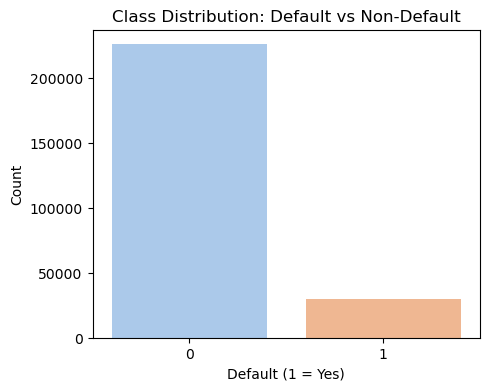

In [2]:
print("Dataset shape:", df.shape)
print("Data types:\n", df.dtypes)
print("\nClass distribution:\n", df['Default'].value_counts(normalize=True))

# Class distribution plot
plt.figure(figsize=(5, 4))
sns.countplot(x='Default', data=df, palette='pastel')
plt.title('Class Distribution: Default vs Non-Default')
plt.xlabel('Default (1 = Yes)')
plt.ylabel('Count')
plt.show()


## Encoding Categorical Variables

In [3]:
categorical_cols = ['Education', 'EmploymentType', 'MaritalStatus', 'HasMortgage',
                    'HasDependents', 'LoanPurpose', 'HasCoSigner']
le = LabelEncoder()
for col in categorical_cols:
    df[col] = le.fit_transform(df[col].astype(str))


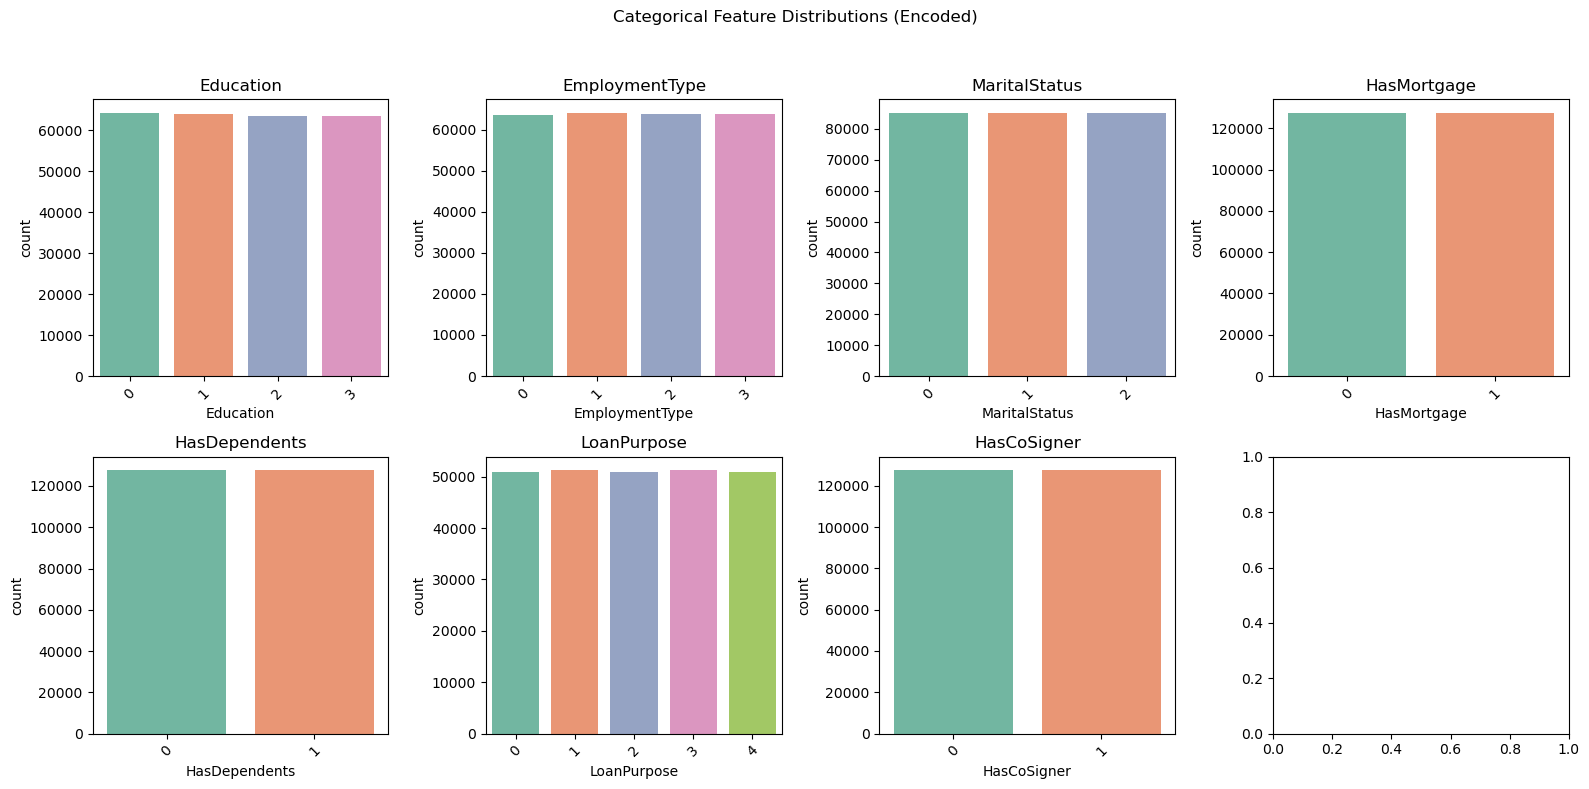

In [4]:
# Plot encoded categoricals
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()
for i, col in enumerate(categorical_cols):
    sns.countplot(x=col, data=df, ax=axes[i], palette='Set2')
    axes[i].set_title(col)
    axes[i].tick_params(axis='x', rotation=45)
plt.suptitle('Categorical Feature Distributions (Encoded)')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


## Numerical Distributions and Correlation Heatmap

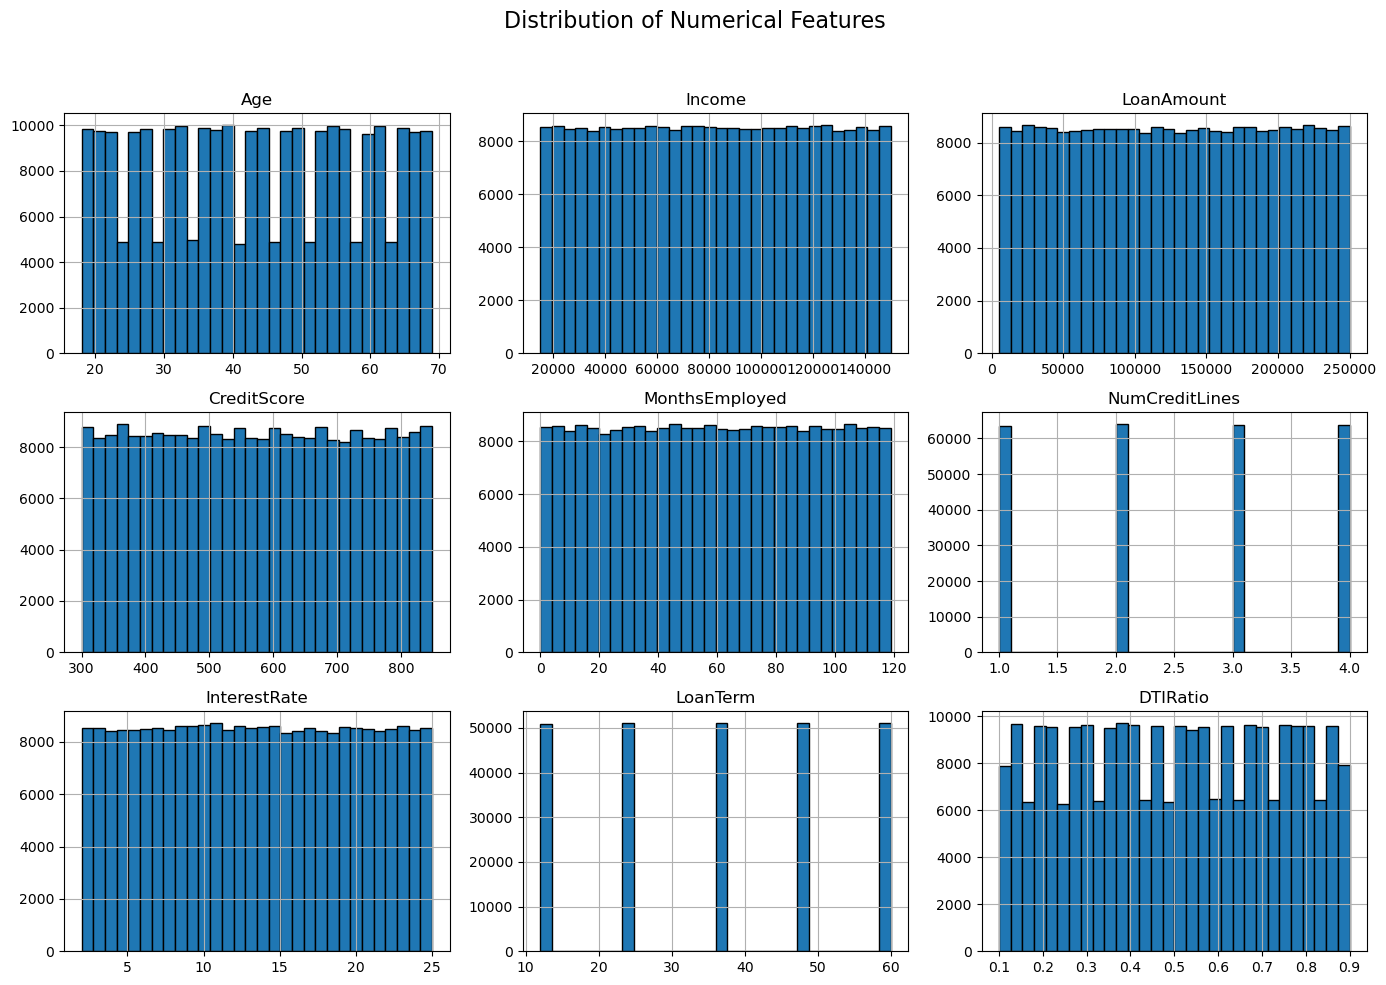

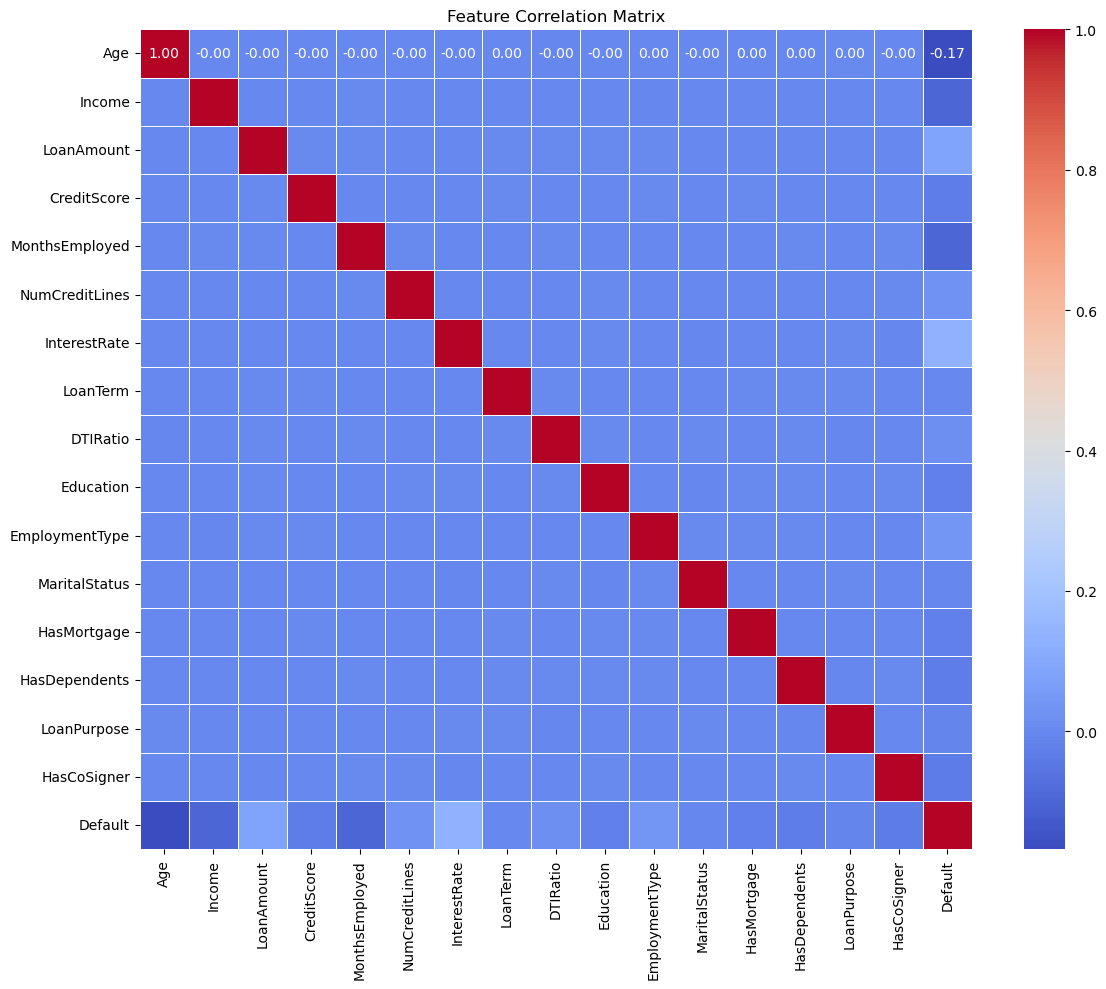

In [5]:
# Drop binned columns if present
df = df[[col for col in df.columns if not col.endswith('_binned') and 'Bin' not in col]]

# Histograms
numeric_cols = ['Age', 'Income', 'LoanAmount', 'CreditScore', 'MonthsEmployed', 
                'NumCreditLines', 'InterestRate', 'LoanTerm', 'DTIRatio']
df[numeric_cols].hist(bins=30, figsize=(14, 10), edgecolor='black')
plt.suptitle("Distribution of Numerical Features", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.show()


## Class Balancing with SMOTE-ENN

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


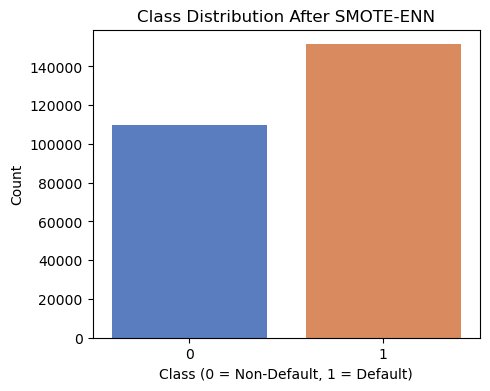

In [6]:
X = df.drop('Default', axis=1)
y = df['Default']

smenn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smenn.fit_resample(X, y)

# Class distribution after resampling
resampled_counts = Counter(y_resampled)
plt.figure(figsize=(5, 4))
sns.barplot(x=list(resampled_counts.keys()), y=list(resampled_counts.values()), palette='muted')
plt.title("Class Distribution After SMOTE-ENN")
plt.xlabel("Class (0 = Non-Default, 1 = Default)")
plt.ylabel("Count")
plt.show()


## Train Random Forest and Evaluate Performance

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, 
                                                    test_size=0.2, random_state=42)

rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight='balanced',
    random_state=42
)
rf.fit(X_train, y_train)

y_probs = rf.predict_proba(X_test)[:, 1]
y_pred = rf.predict(X_test)

auc = roc_auc_score(y_test, y_probs)
print(f"\nAUC Score: {auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))



AUC Score: 0.9076

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.84      0.80     21803
           1       0.88      0.82      0.85     30377

    accuracy                           0.83     52180
   macro avg       0.82      0.83      0.82     52180
weighted avg       0.83      0.83      0.83     52180



## Feature Importance

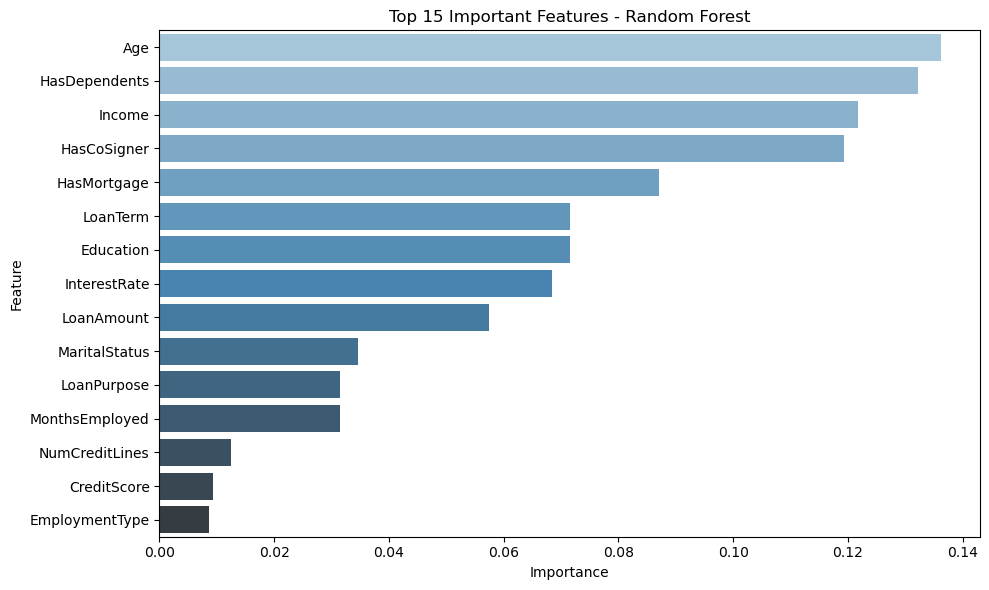

In [8]:
importances = rf.feature_importances_
feat_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feat_df = feat_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feat_df.head(15), palette='Blues_d')
plt.title("Top 15 Important Features - Random Forest")
plt.tight_layout()
plt.show()


## Train Logistic Regression and Evaluate Performance

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Results:
[[14648  7155]
 [ 5987 24390]]
              precision    recall  f1-score   support

           0       0.71      0.67      0.69     21803
           1       0.77      0.80      0.79     30377

    accuracy                           0.75     52180
   macro avg       0.74      0.74      0.74     52180
weighted avg       0.75      0.75      0.75     52180

Logistic Regression AUC: 0.8165


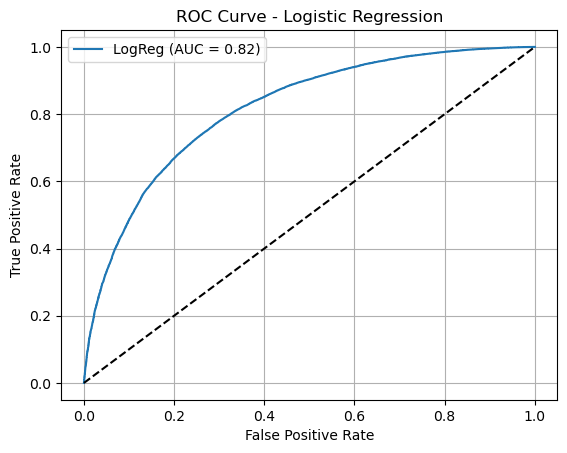

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Train the model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

# Predict classes
y_pred_log = log_reg.predict(X_test)

# Predict probabilities for AUC
y_proba_log = log_reg.predict_proba(X_test)[:, 1]

# Evaluation metrics
print("Logistic Regression Results:")
print(confusion_matrix(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log))

# AUC Score
auc_log = roc_auc_score(y_test, y_proba_log)
print(f"Logistic Regression AUC: {auc_log:.4f}")

# ROC Curve
fpr_log, tpr_log, _ = roc_curve(y_test, y_proba_log)
plt.figure()
plt.plot(fpr_log, tpr_log, label=f'LogReg (AUC = {auc_log:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve - Logistic Regression")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()




## Train XGBoost and Evaluate Performance

/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [14:15:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Results
[[19893  1910]
 [ 3575 26802]]
              precision    recall  f1-score   support

           0       0.85      0.91      0.88     21803
           1       0.93      0.88      0.91     30377

    accuracy                           0.89     52180
   macro avg       0.89      0.90      0.89     52180
weighted avg       0.90      0.89      0.90     52180

XGBoost AUC: 0.9576


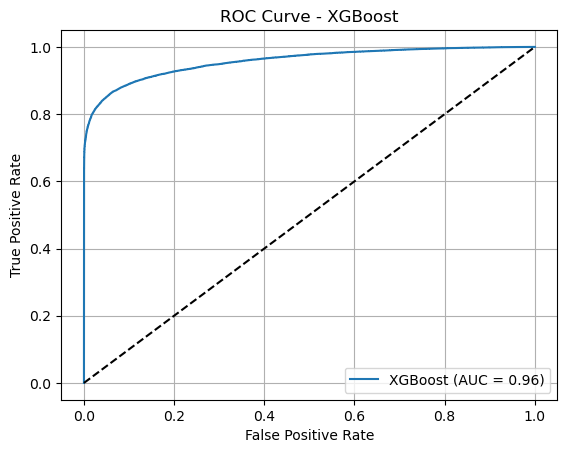

In [10]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)
y_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

print("XGBoost Results")
print(confusion_matrix(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))

auc_xgb = roc_auc_score(y_test, y_proba_xgb)
print(f"XGBoost AUC: {auc_xgb:.4f}")

fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)
plt.figure()
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_xgb:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve - XGBoost")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()

## Train SVM - Linear Kernel and Evaluate Performance

In [11]:
# from sklearn.svm import SVC

# svm_linear = SVC(kernel='linear', probability=True)
# svm_linear.fit(X_train, y_train)

# y_pred_svm = svm_linear.predict(X_test)
# y_proba_svm = svm_linear.predict_proba(X_test)[:, 1]

# print("SVM (Linear Kernel) Results")
# print(confusion_matrix(y_test, y_pred_svm))
# print(classification_report(y_test, y_pred_svm))

# auc_svm = roc_auc_score(y_test, y_proba_svm)
# print(f"SVM (Linear Kernel) AUC: {auc_svm:.4f}")

# fpr_svm, tpr_svm, _ = roc_curve(y_test, y_proba_svm)
# plt.figure()
# plt.plot(fpr_svm, tpr_svm, label=f'SVM Linear (AUC = {auc_svm:.2f})')
# plt.plot([0, 1], [0, 1], 'k--')
# plt.title("ROC Curve - SVM (Linear Kernel)")
# plt.xlabel("False Positive Rate")
# plt.ylabel("True Positive Rate")
# plt.legend()
# plt.grid(True)
# plt.show()

## Train CatBoost and Evaluate Performance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.1/27.1 MB 31.5 MB/s eta 0:00:00a 0:00:01
CatBoost Results
[[21001   802]
 [ 3217 27160]]
              precision    recall  f1-score   support

           0       0.87      0.96      0.91     21803
           1       0.97      0.89      0.93     30377

    accuracy                           0.92     52180
   macro avg       0.92      0.93      0.92     52180
weighted avg       0.93      0.92      0.92     52180

CatBoost AUC: 0.9681


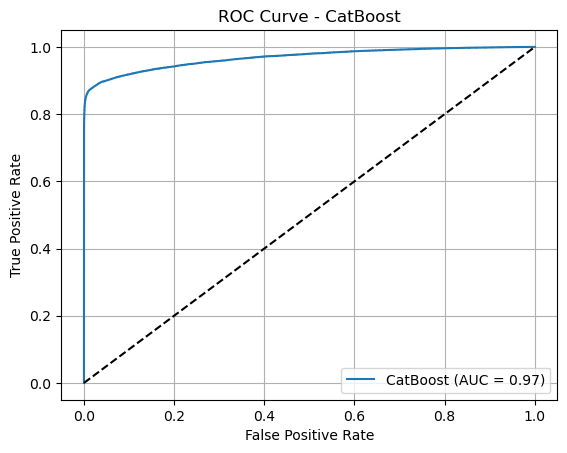

In [13]:
!pip install catboost
from catboost import CatBoostClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Initialize and fit CatBoost
cat_model = CatBoostClassifier(verbose=0)
cat_model.fit(X_train, y_train)

# Predictions
y_pred_cat = cat_model.predict(X_test)
y_proba_cat = cat_model.predict_proba(X_test)[:, 1]

# Evaluation
print("CatBoost Results")
print(confusion_matrix(y_test, y_pred_cat))
print(classification_report(y_test, y_pred_cat))

# AUC Score
auc_cat = roc_auc_score(y_test, y_proba_cat)
print(f"CatBoost AUC: {auc_cat:.4f}")

# ROC Curve
fpr_cat, tpr_cat, _ = roc_curve(y_test, y_proba_cat)
plt.figure()
plt.plot(fpr_cat, tpr_cat, label=f'CatBoost (AUC = {auc_cat:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve - CatBoost")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()


## Train MLP and Evaluate Performance

In [15]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.6/252.6 MB 68.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 81.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 62.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.8/25.8 MB 85.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 671.4/671.4 kB 32.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 83.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 85.6 MB/s eta 0:00:00
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0


In [ ]:
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report
import matplotlib.pyplot as plt

# 1. Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 2. Define the MLP model
mlp_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

mlp_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])

# 3. Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 4. Train the model
history = mlp_model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# 5. Predict
y_proba_mlp = mlp_model.predict(X_test_scaled).ravel()
y_pred_mlp = (y_proba_mlp > 0.5).astype(int)

# 6. Evaluation
print("MLP Model Results")
print(confusion_matrix(y_test, y_pred_mlp))
print(classification_report(y_test, y_pred_mlp))

auc_mlp = roc_auc_score(y_test, y_proba_mlp)
print(f"MLP Model AUC: {auc_mlp:.4f}")

# 7. ROC Curve
fpr_mlp, tpr_mlp, _ = roc_curve(y_test, y_proba_mlp)
plt.figure()
plt.plot(fpr_mlp, tpr_mlp, label=f'MLP (AUC = {auc_mlp:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve - MLP")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()


Epoch 1/100


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5218/5218 ━━━━━━━━━━━━━━━━━━━━ 4s 707us/step - AUC: 0.8726 - loss: 0.4405 - val_AUC: 0.9011 - val_loss: 0.3946
Epoch 2/100
5218/5218 ━━━━━━━━━━━━━━━━━━━━ 4s 694us/step - AUC: 0.8949 - loss: 0.4047 - val_AUC: 0.9038 - val_loss: 0.3879
Epoch 3/100
5218/5218 ━━━━━━━━━━━━━━━━━━━━ 4s 687us/step - AUC: 0.8998 - loss: 0.3953 - val_AUC: 0.9056 - val_loss: 0.3883
Epoch 4/100
5218/5218 ━━━━━━━━━━━━━━━━━━━━ 4s 769us/step - AUC: 0.9011 - loss: 0.3931 - val_AUC: 0.9058 - val_loss: 0.3844
Epoch 5/100
5218/5218 ━━━━━━━━━━━━━━━━━━━━ 4s 704us/step - AUC: 0.9025 - loss: 0.3900 - val_AUC: 0.9067 - val_loss: 0.3818
Epoch 6/100
5218/5218 ━━━━━━━━━━━━━━━━━━━━ 4s 681us/step - AUC: 0.9031 - loss: 0.3889 - val_AUC: 0.9070 - val_loss: 0.3821
Epoch 7/100
5218/5218 ━━━━━━━━━━━━━━━━━━━━ 4s 683us/step - AUC: 0.9033 - loss: 0.3887 - val_AUC: 0.9076 - val_loss: 0.3821
Epoch 8/100
5218/5218 ━━━━━━━━━━━━━━━━━━━━ 4s 692us/step - AUC: 0.9033 - loss: 0.3886 - val_AUC: 0.9083 - val_loss: 0.3786
Epoch 9/100
5218/5218 ━━━━━━